In [40]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math
from math import pi

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

# import basic plot tools
from qiskit.visualization import plot_histogram

# Quantum phase estimation

Quantum phase esimation (QPE) uses the QFT algorithm in order to solve this problem: given unitary $U$ and its eigenvector $|\psi\rangle$, estimate $\theta$ such that $U |\psi\rangle = e^{2 \, \pi \, i \, \theta} |\psi\rangle$. Since $U$ is unitary its eigenvalues have module 1.

It is a very useful subroutine used in many algorithms.

Intuitively, with the QFT we have seen that to encode a number $x$ between 0 and $2^n$ using $n$ qubits in the Fourier basis, we must turn the first qubit by a fraction $\frac{x}{2^n}$ of a full turn, the second qubit by $\frac{2 x}{2^n}$ of a full turn and so on. The algorithm will encode the phase $\theta$ in the Fourier basis so that it is encoded in a number $x \in [0, 2^n]$ and then use the inverse QFT to recover this number.

## Algorithm

The full algorithm uses phase kickback with controlled U operations to encode $\theta$ in the counting register of qubits and then inverse QFT to recover the output. Notice that, without losing in generality, we can assume $0\le\theta\le1$, since higher values would contribute just full rotations, and $2^n \theta \le 2^n$.

The algorithm is as follows:

1. We start with two register, a $n$ qubit counting register and a register to encode $|\psi\rangle$, i.e. the eigenvalue of $U$ such that $|\psi\rangle$, estimate $\theta$ such that $U |\psi\rangle = e^{2 \, \pi \, i \, \theta} |\psi\rangle$
$$
|\psi_0 \rangle = |0^{\otimes n}, \psi \rangle
$$

2. Apply $H^{\otimes n}$ to the counting register
$$
H^{\otimes n}|0^{\otimes n}, \psi\rangle = |+^{\otimes n}, \psi \rangle
$$

3. Now we apply the C-U, controlled U operation, controlled on the counting register qubits and applied to the target register $|\psi \rangle$. Notice that
$$
U^{2^j} |\psi\rangle = U^{2^j-1} U |\psi\rangle = e^{2 \pi i 2^j \theta} |\psi\rangle 
$$
With phase kickback, we can transfer this phase to the control qubit in such a way that this is encoded as a relative phase and not a global un-measurable phase by apply the Hadamards and working in the Fourier basis, so that only the $|1\rangle$ component will get a phase, and in such a way it gives back a Fourier basis state which can then be converted back to computational basis.\
Remembering the intuition in QFT that each qubit is rotated twice as much as the previous one, we apply $n$ controlled operations $C-U^{2^j}$ each controlled on the $0\le j \le n-1$ qubit from the counting register and targeted at $|\psi\rangle$. Notice then that in the current state
$$
C-U |+, \psi\rangle = \frac{1}{\sqrt{2}} \big(|0\rangle + e^{2 \pi i \theta} |1,\rangle\big) \otimes |\psi\rangle
$$
then at last we obtain
$$
\begin{aligned}
|\psi_2\rangle &= C-U^{2^{n-1}} C-U^{2^{n-2}} \dots C-U^{2^0} |+^{\otimes n}, \psi\rangle\\
&=\frac{1}{2^{n/2}} \big( |0\rangle + e^{2 \pi i \, 2^{n-1} \theta} |1\rangle \big) \otimes \dots \otimes \big( |0\rangle + e^{2 \pi i \, 2^{0} \theta} |1\rangle \big) \otimes |\psi\rangle\\
&=\frac{1}{2^{n/2}} \sum_{k=0}^{2^n-1} e^{2 \pi i \, k \theta} |k, \psi\rangle
\end{aligned}
$$
where $k$ is the integer representation corresponding to the binary one.

4. We then apply the inverse QFT. Remember that
$$
\begin{aligned}
QFT_{2^n} |x\rangle &= \frac{1}{2^{n/2}} \big( |0\rangle + e^{\frac{2 \pi i}{2} x} |1\rangle \big) \otimes \dots \otimes \big( |0\rangle + e^{\frac{2 \pi i}{2^n} x} |1\rangle \big)\\
&= \frac{1}{2^{n/2}} \sum_{j=0}^{2^n-1} e^{\frac{2 \pi i x j}{2^n}} |j\rangle
\end{aligned}
$$
and notice that at step 3 we did obtain a very similar state with each qubit rotated on its $|1\rangle$ component by a phase twice than the qubit before. Thus the above is equivalent to applying a QFT to an initial state with $x=2^n \theta$, as can be seen directly comparing the two formulas. If $\theta$ can actually be expressed using $n$ qubits, i.e. we can write $\theta=0.\theta_1 \dots \theta_n = \sum_{j=0}^{n} 2^{-j} \theta_j$, it means that the state $|\psi_2\rangle$ can actually be obtained by applying the QFT to $|2^n \theta\rangle$ and thus applying an inverse QFT we get exactly\
$$
QFT_{2^n}^{\dagger} |\psi_2\rangle=|2^n \theta\rangle = |\theta_1 \dots \theta_n\rangle
$$
hence measuring the Z basis will give exactly the bits of $\theta$. If $\theta$ cannot be expressed exactly using $n$ bits, we can still obtain a good approximation of the correct result $|2^n \theta\rangle$ with high probability with the procedure above.\
Infact, more in general we have that 
$$
QFT^{\dagger} |k\rangle = \frac{1}{2^{n/2}} \sum_{j=0}^{2^n-1} e^{-\frac{2 \pi i k j}{2^n}} |j\rangle
$$
Then, applying this to $|\psi_2\rangle$
$$
|\psi_3\rangle = QFT^{\dagger} |\psi_2\rangle = \frac{1}{2^n} \sum_{j,k=0}^{2^n-1} e^{\frac{-2 \pi i k}{2^n} (j - 2^n \theta)} |j\rangle \otimes |\psi\rangle
$$
Consider now $b/2^n=0.b_1 \dots b_n$ such that $0 \le \delta = \theta - b/2^n \le 2^{-n}$ (best $n$ bit approximatino to $\theta$ from below), the amplitude of the component $|b+j \text{ (mod $2^n$)}\rangle$ is
$$
\alpha_j = \frac{1}{2^n} \sum_{k=0}^{2^n-1} \bigg(e^{\frac{-2 \pi i}{2^n} (b+j - 2^n \theta)}\bigg)^k = \frac{1}{2^n} \frac{1-e^{2 \pi i (2^n \delta - j)}}{1-e^{2 \pi i (\delta - j/2^n)}}
$$
Suppose we want $\theta$ with accuracy $2^{-t}$, it can be shown that in order to obtain an approximation within this accuracy with probability at least $1-\epsilon$ we must choose
$$
n = t + \log \big(2+\frac{1}{2 \epsilon}\big)
$$
So by choosing $n$ correctly we can ensure to have a good probability of obtaining an approximation within accuracy $2^{-t}$.

5. We then measure in the computational basis and obtain either $2^n \theta = \theta_1 \dots \theta_n$, if $2^n \theta$ is an integer, or a good approximation of it.

## Example: T-gate

We now apply the above QPE algorithm to try and measure the $T=U_1(\pi/4)$ gate phase. Remember that

$$
T|1\rangle = e^{i \frac{\pi}{4}}|1\rangle=e^{2 \pi i \frac{1}{8}} |1\rangle
$$

so we expect to find $\theta=1/8$. We will use 3 qubits in the counting register since it's what we need to obtain an ''exact'' result.

We will need 4 qubits, one for T to act on and 3 for the counting register. Here we put $|\psi\rangle=|1\rangle$ since it's the only one with a phase $\theta\ne0$

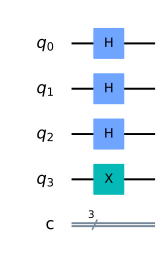

In [34]:
qpe = QuantumCircuit(4,3)
qpe.x(3)
#Hadamard on the counting qubits
for q in range(3):
    qpe.h(q)
qpe.draw()

Now we apply the $C-U^{2^j}$ operations for $j=0,1,2$, remember that qiskit order the qibits the other way around.

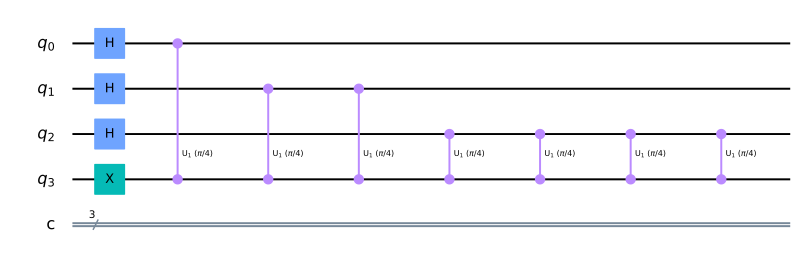

In [35]:
repetitions=1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cu1(pi/4, counting_qubit, 3) #C-U
    repetitions*=2
qpe.draw()

Now we need to apply the $QFT^{\dagger}$, here we just take the same algorithm as in section 3.7 and use it

In [36]:
def qft_rotations(circuit, n):
    """Performs qft recursively starting from the n-th qubit down to the least significant qubit with n=0"""
    if n==0:
        return circuit
    n -= 1 #index start from 0
    circuit.h(n) #apply H gate to the current most significant qubit
    for qubit in range(n-1,-1,-1): #goes from n-1 to 0, i inverted it respect to the book so that the gates are applied in order
        # For each less significant qubit, apply a smaller angled rotation 
        # if it is 1
        circuit.cu1(pi/(2**(n-qubit)), qubit, n)
    # At the end, we call the same function on the next qubit
    circuit.barrier()
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n):
    """Does the inverse of qft on the first n qubits in circuit"""
    #We create a dummy QC which applies QFT
    qft_circ = qft(QuantumCircuit(n),n)
    # Then we invert the circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() #decompose allows us to see the individual gates 

And last we measure the counting register

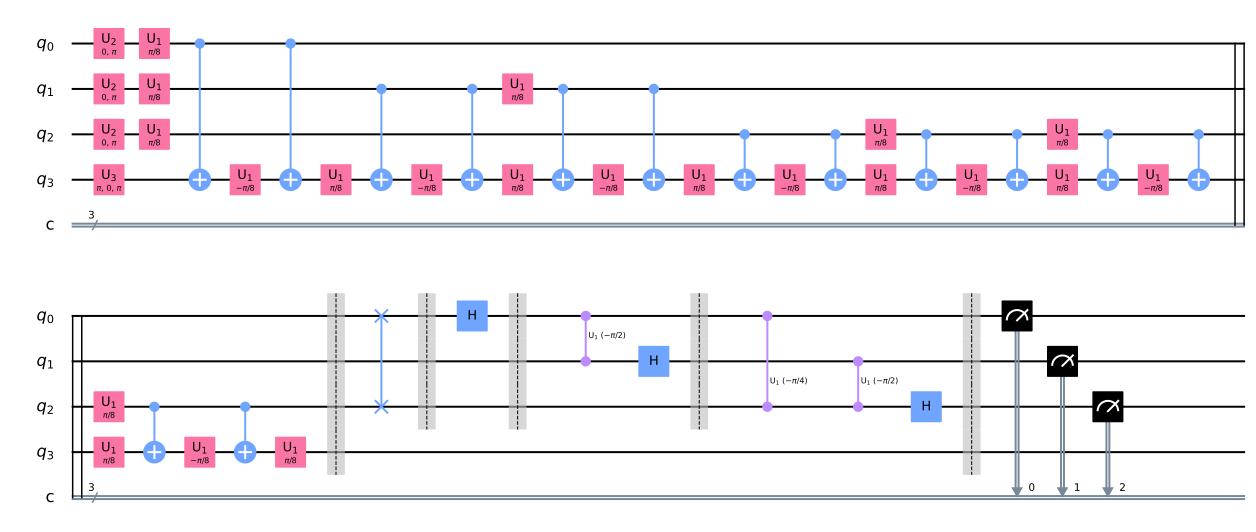

In [37]:
qpe.barrier()
qpe = inverse_qft(qpe, 3) #Inverse QFT
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)
qpe.draw()

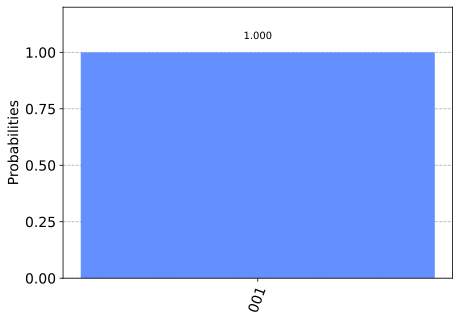

In [84]:
aer_backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpe, aer_backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

So we got $001_2=1_{10}$ with certainty, how does it translates to what we expected? Notice that we expected to get $2^3 * \theta = 2^3 * 2^{-3}=1$, which is exactly what we got. To obtain the value of $\theta$ we must divide by $2^3$ and thus get 

$$
\theta = 1/2^3 = 1/8 = 0.001_2
$$

exactly what we expected.

## Example: more precision

Let's drop $T$ and use now a gate with $\theta=1/3$, which obviously cannot be expressed exactly in binary form. The circuit is the same as before, just modify the `cu1` operation. Furthermore, for simplicity we won't use the $QFT^{\dagger}$ as before but we rewrite it as

In [25]:
def qft_dagger(circ, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            circ.cu1(-pi/float(2**(j-m)), m, j)
        circ.h(j)

This is clearly the correct operation, check the previous section about QFT. This allows us to avoid using `decompose` which kind of messes up our circuit. So, the full code now is

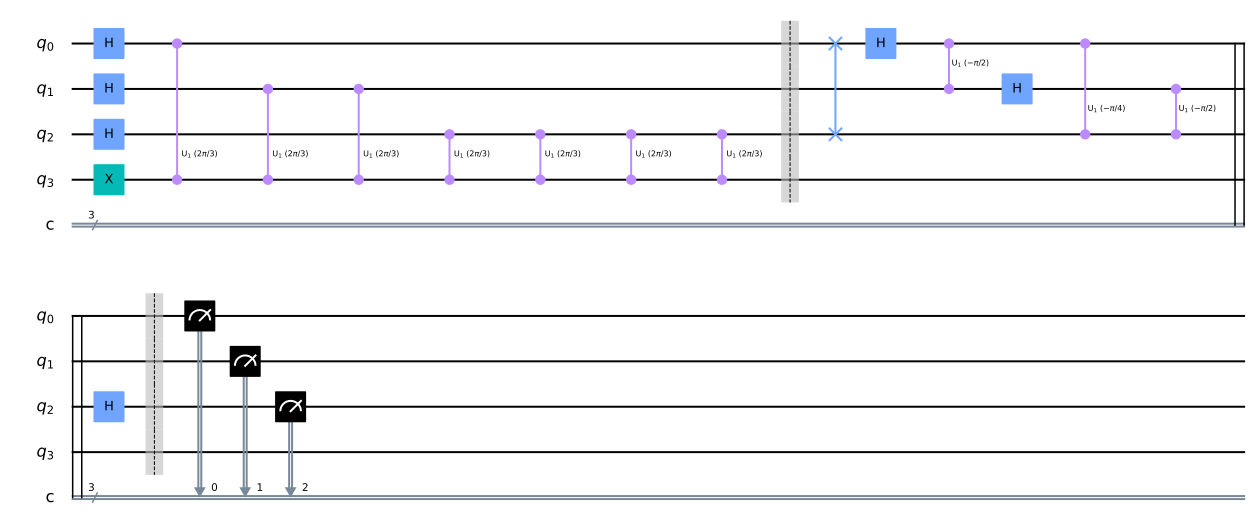

In [27]:
qpe_2 = QuantumCircuit(4,3)

qpe_2.x(3)
for q in range(3):
    qpe_2.h(q)

repetitions=1
for cq in range(3):
    for r in range(repetitions):
        qpe_2.cu1(2*pi/3, cq, 3)
    repetitions*=2

qpe_2.barrier()
qft_dagger(qpe_2, 3)
qpe_2.barrier()

for n in range(3):
    qpe_2.measure(n,n)

qpe_2.draw()

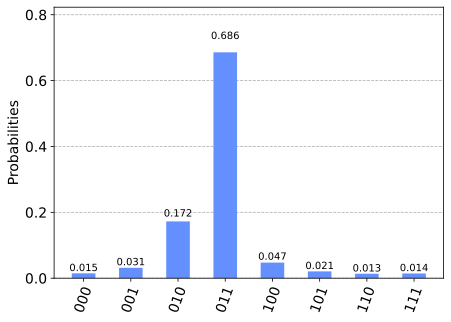

In [30]:
shots = 4096
results = execute(qpe_2, aer_backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

We see that we don't get an exact result, but a most likely result of $011_2=3_{10}$ and some other less likely results. This is as expected, since $2^n \theta = 8/3$ is not an integer, thus we cannot get an exact result, we got the closer approximation available with $3$ bits, i.e. $0.011=1/4+1/8=3/8=0.375$ (off by $13\%$), instead of $\theta=1/3=0.333\dots$, and the second most likely result is $010_2=2_{10}$ which gives $0.25$ (off by $25\%$). We see that $\theta$ lies between the values we can get with $3$ bit, so we have it with at most $2^{-3}=1/8=0.125$ precision.

To have a more precise result, we must simply add more counting qubits! Let's add two:

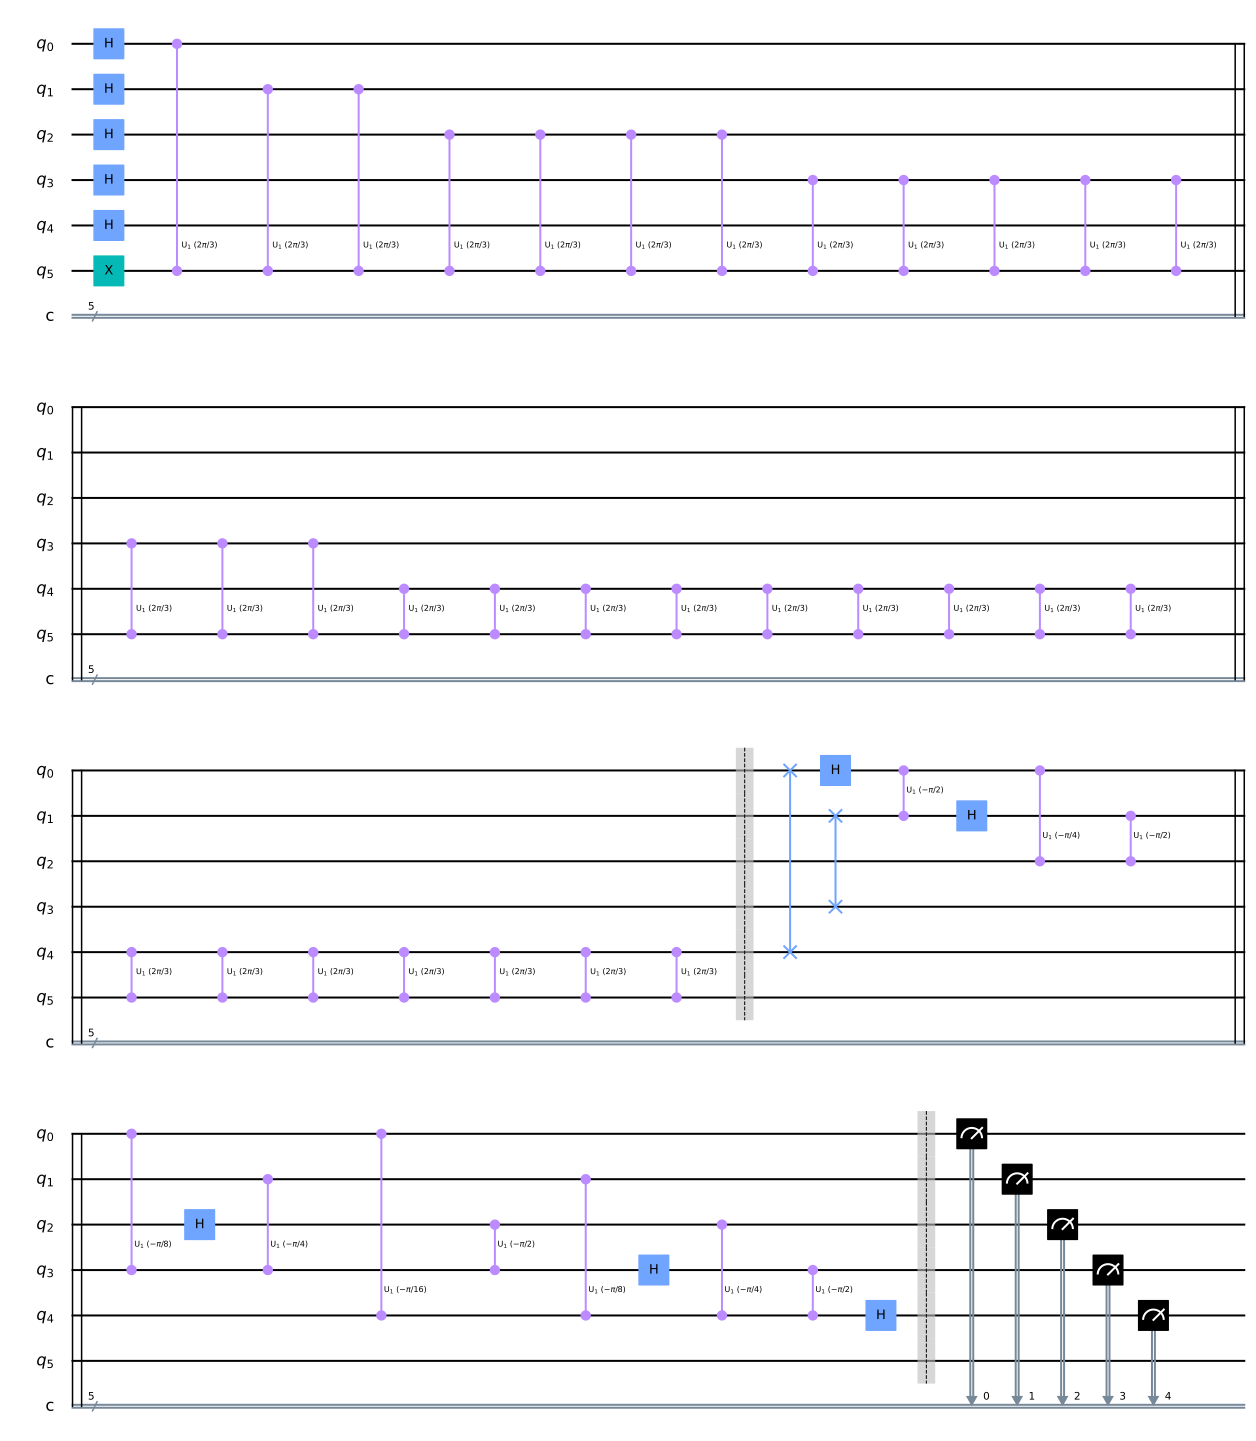

In [65]:
qpe_3 = QuantumCircuit(6,5)

qpe_3.x(5)
for q in range(5):
    qpe_3.h(q)

repetitions=1
for cq in range(5):
    for r in range(repetitions):
        qpe_3.cu1(2*pi/3, cq, 5)
    repetitions*=2

qpe_3.barrier()
qft_dagger(qpe_3, 5)
qpe_3.barrier()

for n in range(5):
    qpe_3.measure(n,n)

qpe_3.draw()

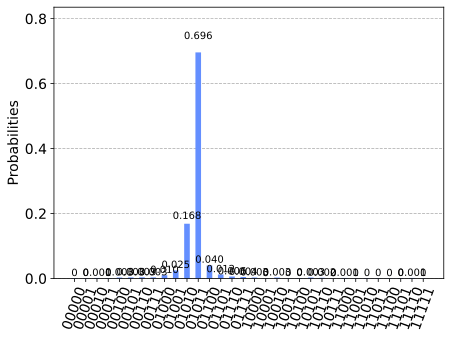

In [66]:
shots = 4096
results = execute(qpe_3, aer_backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [67]:
def get_top_n_max(dictionary, n):
    max_n_values = sorted(dictionary.values())[-n:]
    keys = [k for k, v in dictionary.items() if v in max_n_values]
    return keys

print("The top two answers are: ", get_top_n_max(answer, 2))

The top two answers are:  ['01010', '01011']


Now the most likely results are $01011_2=11_{10}$ and $01010_2=10_{10}$, which give

$$
\theta = 11/2^5=0.344 \quad \theta = 10/2^5=0.313
$$

These two results are much closer to $1/3$, the first differs by $3\%$ and the second by $6\%$.

## Real devices

Let's run the $T$ gate circuit on a real device

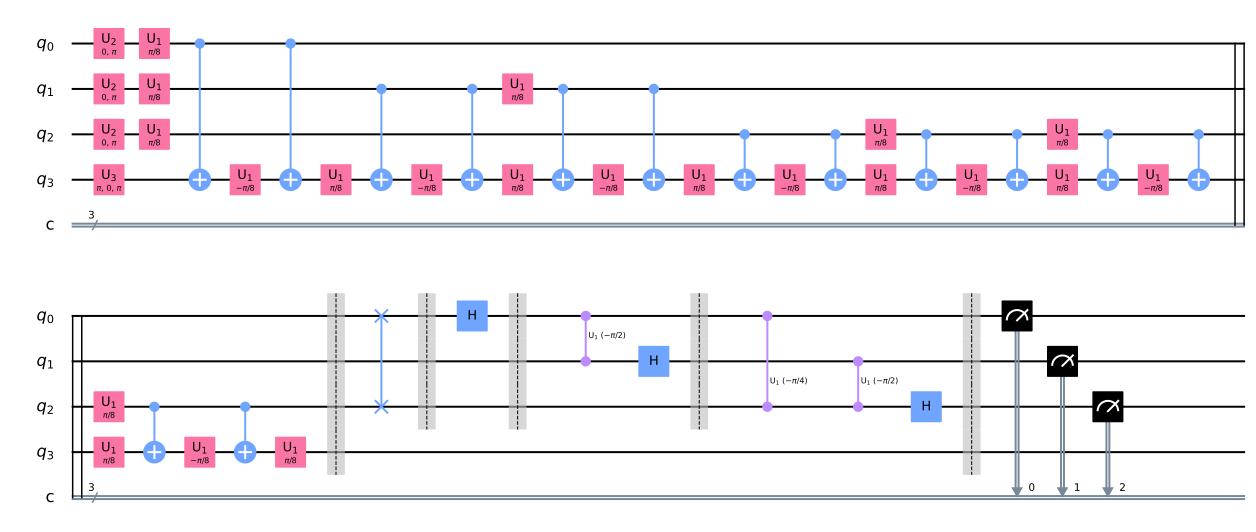

In [68]:
qpe.draw()

In [69]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
IBMQ_backend = provider.get_backend('ibmq_vigo')

/home/luigi/.venvs/qiskit-textbook/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-12-31 13:57:58,193: Credentials are already in use. The existing account in the session will be replaced.


In [70]:
shots=2048
job = execute(qpe, backend=IBMQ_backend, shots=shots, optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


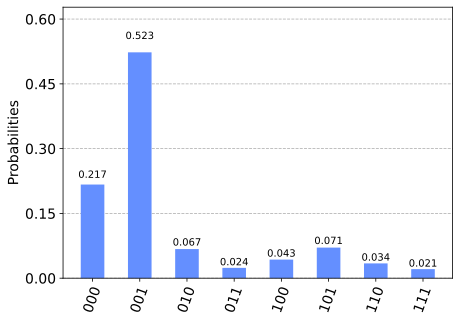

In [71]:
result = job.result().get_counts(qpe)
plot_histogram(result)

In [72]:
print("The top two answers are: ", get_top_n_max(result, 2))

The top two answers are:  ['000', '001']


We get the most likely result $001_2=1_{10}$ as before, but with quite some errors. This an be an issue as this other result are not due to imprecision in our approximation of $\theta$, but are due just on the hardware errors.

Let's try the very last circuit, notice we need a new backend with at least 6 qubits

In [73]:
IBMQ_backend_2 = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits>=6
                                             and not b.configuration().simulator
                                             and b.status().operational==True))
print("backend: ", IBMQ_backend_2, ", qubits: ", IBMQ_backend_2.configuration().n_qubits)

backend:  ibmq_16_melbourne , qubits:  15


In [74]:
shots=4096
job = execute(qpe_3, backend=IBMQ_backend_2, shots=shots, optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


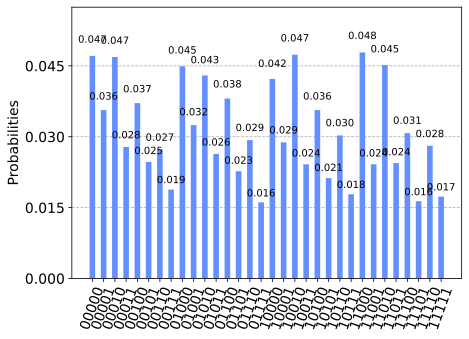

In [75]:
result_2 = job.result().get_counts(qpe_3)
plot_histogram(result_2)

In [76]:
print("The top two answers are: ", get_top_n_max(result_2, 2))

The top two answers are:  ['10010', '11000']


And that's a mess due to hardware errors and algorithm uncertainty mixing up.

In order to actually apply the QPE algorithm we need to know $\theta$ beforehand, so it might seem a little pointless, but it's a very useful algorithm for further ones like Shor's.

### Exercises

The first is a bit boring, trying $Y$ gate. We can get $Y$ eigenvalue by using $H$ and then $S$

$$
S|\pm\rangle= 
\begin{bmatrix}
1 & 0\\
0 & e^{i \pi/2}\\
\end{bmatrix}
\begin{bmatrix}
1/\sqrt{2}\\
\pm 1/\sqrt{2}
\end{bmatrix}=
\begin{bmatrix}
1/\sqrt{2}\\
\pm i/\sqrt{2}
\end{bmatrix}
=|\psi_{\pm}\rangle
$$

which are the eigenvalues of $Y$

$$
Y |\psi_{\pm}\rangle = 
\begin{bmatrix}
0 & -i\\
i & 0
\end{bmatrix}
\begin{bmatrix}
1/\sqrt{2}\\
\pm i/\sqrt{2}
\end{bmatrix} =
\pm |\psi_{\pm}\rangle
$$

as expected. Thus the circuit is as above, just need to put the ancillary $|\psi\rangle$ qubit needed for phase kickback in the correct state. The phase we expect is

$$
Y |\psi_-\rangle = - |\psi_-\rangle = e^{2 \pi i /2} |\psi_- \rangle \implies \theta=1/2
$$

We only need 1 qubit, and we now need a controlled $Y$ operation, which according to 2.4 from this book can be done using CNOTs in the following way: we just need to transform the Y basis into the X basis with the $S$ and $S^{\dagger}$ rotations and apply a single CNOT inbetween.

In [111]:
def cy(circuit, c, t):
    circuit.sdg(t)
    circuit.cx(c,t)
    circuit.s(t)

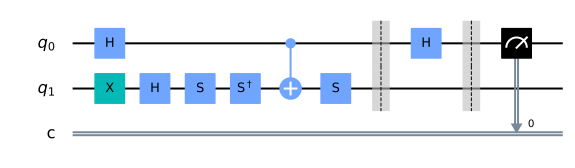

In [113]:
nqubits = 1
qpe_ex = QuantumCircuit(nqubits+1,nqubits)

#we put the last qubit in the |\psi_-> state
qpe_ex.x(nqubits)
qpe_ex.h(nqubits)
qpe_ex.s(nqubits)

for q in range(nqubits):
    qpe_ex.h(q)

repetitions=1
for cq in range(nqubits):
    for r in range(repetitions):
        cy(qpe_ex, cq, nqubits)
    repetitions*=2

qpe_ex.barrier()
qft_dagger(qpe_ex, nqubits)
qpe_ex.barrier()

for n in range(nqubits):
    qpe_ex.measure(n,n)

qpe_ex.draw()

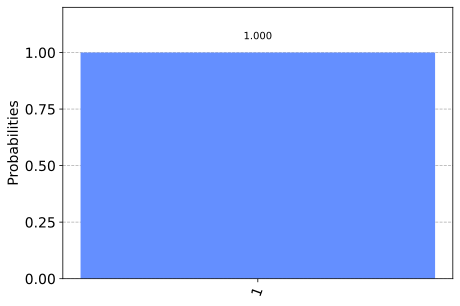

In [114]:
shots = 4096
results = execute(qpe_ex, aer_backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

We used a Controlled-Y operation with 1 qubit and another ancillary one set to the negative eigenvector of $Y$. We got as expected $2*\theta=1 \implies \theta=1/2$.